## Song Embeddings - Skipgram Recommender

In this notebook, we'll use human-made music playlists to learn song embeddings. We'll treat a playlist as if it's a sentence and the songs it contains as words. We feed that to the word2vec algorithm which then learns embeddings for every song we have. These embeddings can then be used to recommend similar songs. This technique is used by Spotify, AirBnB, Alibaba, and others. It accounts for a vast portion of their user activity, user media consumption, and/or sales (in the case of Alibaba).

The [dataset we'll use](https://www.cs.cornell.edu/~shuochen/lme/data_page.html) was collected by Shuo Chen from Cornell University. The dataset contains playlists from hundreds of radio stations from around the US.

## Importing packages and dataset

In [3]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from urllib import request
import warnings
warnings.filterwarnings('ignore')
import gensim.downloader as api
import matplotlib.pyplot as plt #to generate the t-SNE plot
from sklearn.manifold import TSNE #scikit learn's TSNE
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

1.**Obtener conjunto de datos:** El conjunto de datos de Listas de Reproducción es un archivo de texto que contiene en cada una de sus filas los 'ID' de las caciones que componen esa lista de reproducción. Quitamos las dos primeras filas que contenían metadata que no nos interesa y posteriormente eliminamos las listas dereproducción que sólo tienen una canción.

In [4]:

data = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/train.txt')

lines = data.read().decode("utf-8").split('\n')[2:]

playlists = [s.rstrip().split() for s in lines if len(s.split()) > 1]


Acá vemos un ejemplo de las dos primeras líneas.

In [5]:
print( 'Playlist #1:\n ', playlists[0], '\n')
print( 'Playlist #2:\n ', playlists[1])

Playlist #1:
  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '2', '42', '43', '44', '45', '46', '47', '48', '20', '49', '8', '50', '51', '52', '53', '54', '55', '56', '57', '25', '58', '59', '60', '61', '62', '3', '63', '64', '65', '66', '46', '47', '67', '2', '48', '68', '69', '70', '57', '50', '71', '72', '53', '73', '25', '74', '59', '20', '46', '75', '76', '77', '59', '20', '43'] 

Playlist #2:
  ['78', '79', '80', '3', '62', '81', '14', '82', '48', '83', '84', '17', '85', '86', '87', '88', '74', '89', '90', '91', '4', '73', '62', '92', '17', '53', '59', '93', '94', '51', '50', '27', '95', '48', '96', '97', '98', '99', '100', '57', '101', '102', '25', '103', '3', '104', '105', '106', '107', '47', '108', '109', '110', '111', '112', '113', '25', '63', '62', '114', '115', '84', '116', '117',

2. **Modelado:**  Ya el conjunto de datos tienen la forma adecuada que  el modelo Word2vec espera como entrada.

In [6]:
model = Word2Vec(playlists, vector_size=32, window=20, negative=50, min_count=1, workers=4)

Hasta este punto, el modelo ya fue entrenado y se incluyó un embedding. Como vimos, estas filas sólo contienen id de caciones, ahora vamos a integrarlo con el restode información de las mismas como Titulo de las caciones y artista.

3. **Complementamos datos de las listas:**

A continuación leemos el conjunto de datos que contiene los demás datos y lo transformamos en un data frame de pandas.

In [7]:
songs_file = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/song_hash.txt')
songs_file = songs_file.read().decode("utf-8").split('\n')
songs = [s.rstrip().split('\t') for s in songs_file]

In [8]:
songs_df = pd.DataFrame(data=songs, columns = ['id', 'title', 'artist'])
songs_df = songs_df.set_index('id')

Así se visualizan los primeros 5 registros del dataframe.

In [9]:
songs_df.head()

,title,artist
id,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross
2,Get Back Up (w\/ Chris Brown),T.I.
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher
4,Whip My Hair,Willow


### Exercise:
4. **Visualización del Embedding:**

A partir de este punto debemos visualizar el embedding de las caciones recomendadas.

Acá a través del método most_similar que trae ya Word2vec traemos las caciones más similares dado un id de canción.

In [10]:
song_id = 2172
model.wv.most_similar(positive=str(song_id))

[('5586', 0.9990074634552002),
 ('11473', 0.9974859952926636),
 ('5634', 0.9968708753585815),
 ('6641', 0.9963157773017883),
 ('10105', 0.9959679841995239),
 ('1922', 0.9952524900436401),
 ('3148', 0.9952155947685242),
 ('2976', 0.9948354959487915),
 ('6626', 0.9946886301040649),
 ('3126', 0.9946063160896301)]

In [11]:
similar_songs = np.array(model.wv.most_similar(positive=str(song_id)))[:,0]
title = songs_df.iloc[similar_songs]['title']

In [12]:
print(title)

id
5586        The Last In Line
11473         Little Guitars
5634          Mr. Brownstone
6641      Shout At The Devil
10105         Three Lock Box
1922                     One
3148         Big City Nights
2976            I Don't Know
6626                Blackout
3126             Heavy Metal
Name: title, dtype: object


A continuación, para cada canción de referencia se identifica las 30 canciones más similares según el modelo, posteriormente se almacenan  los títulos de estas canciones similares y sus vectores de embedding en listas separadas.

El resultado final son dos listas:

word_clusters: Contiene listas de títulos de canciones similares para cada canción de referencia.
embedding_clusters: Contiene listas de vectores de embedding para las canciones similares de cada canción de referencia.

In [13]:
keys = [2172, 333, 12, 16]
embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        # Convertimos similar_word a entero para usar como índice de fila
        song_index = int(similar_word)

        # Accedemos al título usando el índice de fila
        title = songs_df.iloc[song_index]['title']

        words.append(title)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [14]:
print(word_clusters)

[['They Gonna Talk', 'Police In Helicopter', 'Saddest Day', 'Roller Skates', "It's O.K.", 'Everyone Falls In Love', 'No Disturb Sign', 'Down By The River', 'Sweetness', 'Love Is', 'Kindness For Weakness', 'Getty Getty No Wantee', 'Beautiful Lady', 'Telephone Love', 'Rock Away', "Hold My Hand (I'll Be There) (w\\/ Keri Hilson)", 'More Life', 'Night Nurse', 'Thank You Mamma', 'Come Over', 'Love Created I', 'Princess Gone', 'Frenzy', 'Falling In Love', 'Angel Eyes', 'August Town', 'No Letting Go', 'Paradisin', "She's Mine", 'Trini 2 D Bone'], ['So Incredible', 'I Belong To The Band', 'Ups And Downs', 'Whisper', 'Unwind', 'Alive', 'I Wanna', 'The BBQ (w\\/ Rah Digga & Rage)', 'Genuine', 'Write Me A Letter (w\\/ Braddah Vince)', 'All For You', 'No One', 'Need Me (Every Night)', 'Building Steam With A Grain Of Salt', "I'll Be Good", "I'm Yours", 'Where You Are', 'Shawty', 'Undercover Lover', 'Happy (To Have A Job)', 'Dancing In The Minefields', "Don't Knock", 'Rocketeer (w\\/ Ryan Tedder)', 

Generamos esta función que nos permite imprimir las canciones similares por cada id.

In [15]:
def print_recommendations_list(song_ids):
    all_recommendations = []

    for song_id in song_ids:
        # Imprime la información de la canción actual
        print(songs_df.iloc[song_id])

        # Obtiene las canciones similares
        similar_songs = np.array(model.wv.most_similar(positive=str(song_id)))[:, 0]

        # Agrega las recomendaciones a la lista
        all_recommendations.append(songs_df.iloc[similar_songs])

    return all_recommendations

In [16]:
song_ids = keys

recommendations = print_recommendations_list(song_ids)
for i, rec in enumerate(recommendations):
    print(f"Recomendaciones para la canción con ID {song_ids[i]}:")
    print(rec)

title     Fade To Black
artist        Metallica
Name: 2172 , dtype: object
title     Hit 'Em Up (w\/ The Outlawz)
artist                            2Pac
Name: 333 , dtype: object
title     Who's That Chick
artist             Rihanna
Name: 12 , dtype: object
title     Put It In A Love Song (w\/ Beyonce)
artist                            Alicia Keys
Name: 16 , dtype: object
Recomendaciones para la canción con ID 2172:
                     title         artist
id                                       
5586      The Last In Line            Dio
11473       Little Guitars      Van Halen
5634        Mr. Brownstone  Guns N' Roses
6641    Shout At The Devil    Motley Crue
10105       Three Lock Box    Sammy Hagar
1922                   One      Metallica
3148       Big City Nights      Scorpions
2976          I Don't Know  Ozzy Osbourne
6626              Blackout      Scorpions
3126           Heavy Metal    Sammy Hagar
Recomendaciones para la canción con ID 333:
                                

A continuación usamos t-SNE para reducir la dimensionalidd de del conjunto de vectores de embedding de las caciones. Esto nos permitirá hacer una visuaización en un espacio de dos dimensiones.
Utilizamos una perplexity = 10 que es la cantidad de vecinos efectivos que considerará la reducción de dimensionalidad.

In [17]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape #geting the dimensions
tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=1500, random_state=2020)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2) #reshaping it into 2d so we can visualize it

Por último, utilizamos matplotlib para la visualización de las recomendaciones de cada uno de los clúster identificados con un color diferente cada uno.

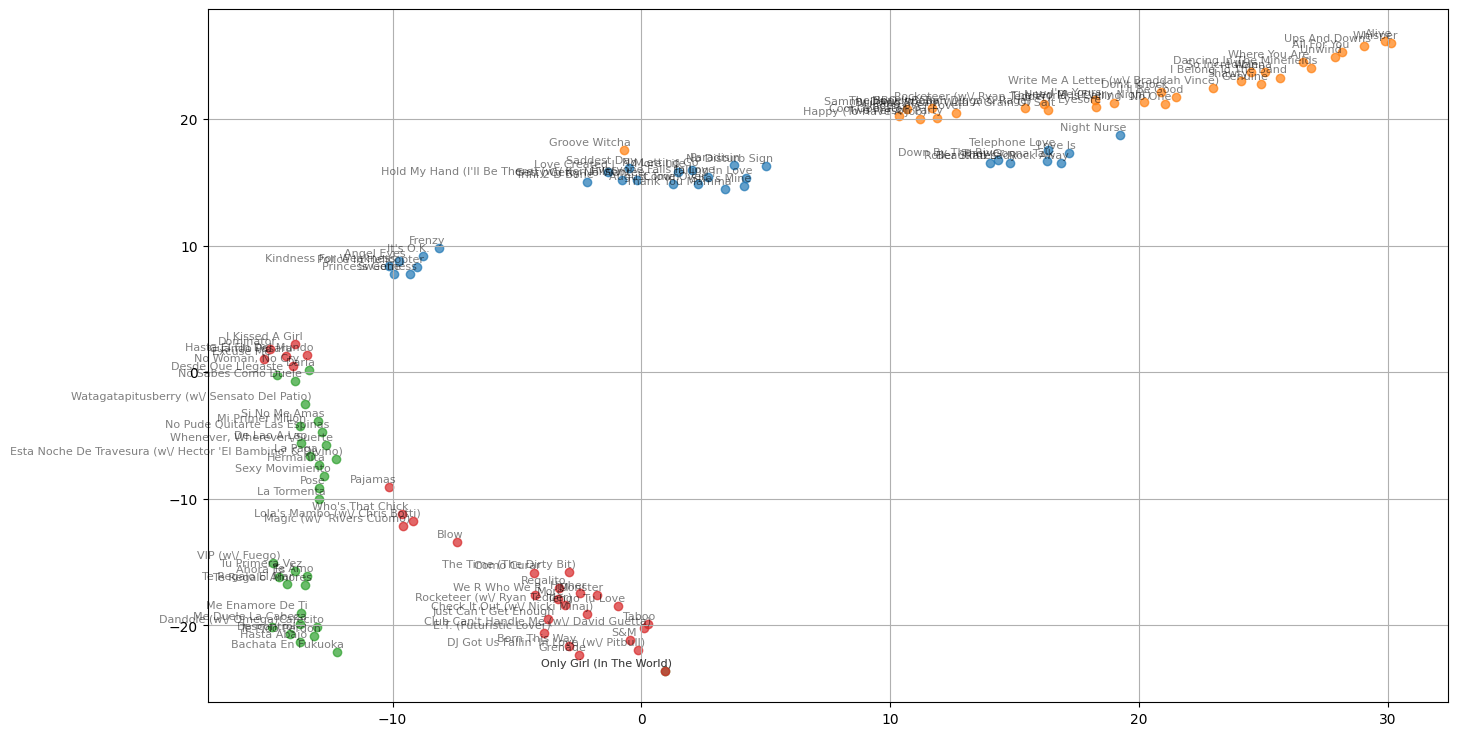

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

#script for constructing two-dimensional graphics using Matplotlib
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))


    for label, embeddings, words in zip(labels, embedding_clusters, word_clusters):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.grid(True)
    plt.show()

tsne_plot_similar_words(words, embeddings_en_2d, word_clusters)